# Debug TF, fix DQN and check 1000 ep test.
```
    num_dcs = 10
    num_customers = 2
    num_commodities = 4
    orders_per_day = 2
    dcs_per_customer = 3
    demand_mean = 100
    demand_var = 20

    num_steps = 50
    num_episodes = 1000
```
Commit: 78c4b3c393072d593abd98227b70f67cdc29877d


In [2]:
import tensorflow.compat.v1 as tf
import numpy as np

In [3]:
tf.one_hot(tf.constant([6]),depth=10).shape

TensorShape([1, 10])

In [4]:
tf.reset_default_graph()
q_state=tf.dtypes.cast(tf.constant(np.array([[5.0,10.0,25.0],[5.0,10.0,25.0],[5.0,10.0,25.0]])),dtype=tf.float32)
print(q_state.shape)
print(q_state.dtype)
action = tf.dtypes.cast(tf.transpose(tf.one_hot(tf.constant(2),depth=3)),dtype=tf.float32)
print(action.dtype)
print(action.shape)

tf.multiply(q_state,action)

q_action = tf.reduce_sum(tf.multiply(q_state,action))
print(q_action)

target_in=tf.constant(100.0)
loss = target_in-q_action
print(loss)

(3, 3)
<dtype: 'float32'>
<dtype: 'float32'>
(3,)
tf.Tensor(75.0, shape=(), dtype=float32)
tf.Tensor(25.0, shape=(), dtype=float32)


In [5]:
import pandas as pd
detail=pd.read_csv('/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/data/results/two_customers_dqn_debug_sample/ep_0/movement_detail_report.csv')
def add_is_m(df):
    df['unit_cost']=(df.customer_cost/df.customer_units).fillna(0)
    df['is_m'] = df.unit_cost==1000
    return df
detail=add_is_m(detail)
detail.query('customer_cost>0').groupby('is_m').size().reset_index()

,is_m,0
0,False,10
1,True,174


NOW WE TALKING.

# 100 EP TEST

In [6]:
detail_100=pd.read_csv('/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/data/results/two_customers_dqn_debug_sample/ep_99/movement_detail_report.csv')
detail_100=add_is_m(detail_100)
detail_100.query('customer_cost>0').groupby('is_m').size().reset_index()

,is_m,0
0,True,184


Checking what decisions are being made in the end

In [7]:
print("choices at ep 1")
display(detail.query('customer_cost>0').groupby(["source_name",'destination_name','is_m']).size().reset_index().sort_values(['destination_name']))
print("choices at ep 100")
display(detail_100.query('customer_cost>0').groupby(["source_name",'destination_name','is_m']).size().reset_index().sort_values(['destination_name']))

choices at ep 1


,source_name,destination_name,is_m,0
0,dcs_1,c_10,False,2
2,dcs_3,c_10,True,2
3,dcs_4,c_10,False,2
5,dcs_5,c_10,True,80
7,dcs_6,c_10,False,2
8,dcs_8,c_10,True,2
9,dcs_9,c_10,True,2
1,dcs_1,c_11,True,2
4,dcs_4,c_11,False,4
6,dcs_5,c_11,True,86


choices at ep 100


,source_name,destination_name,is_m,0
0,dcs_5,c_10,True,88
2,dcs_7,c_10,True,2
3,dcs_8,c_10,True,2
1,dcs_5,c_11,True,92


Now it seems the network understood the big Ms better, but still rewards are really big and i don't know if they reflect that 

Customer cost is down by 1 million cost units

In [8]:
print(detail.customer_cost.sum())
print(detail_100.customer_cost.sum())

86115500
91822000


Total costs also seem to be down by 60 million. Check and see why prints of total sum of rewards are so similar. Maybe they are cumulative?

In [9]:
summary_1=pd.read_csv("/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/data/results/two_customers_dqn_debug_sample/ep_11/summary_movement_report.csv")
summary_100=pd.read_csv("/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/data/results/two_customers_dqn_debug_sample/ep_99/summary_movement_report.csv")
print(summary_1.total_cost.sum())
print(summary_100.total_cost.sum())

92474370
92721690


Plot cost across EPS:

In [10]:
ep_costs=[]
num_eps=1000
for i in range(1,num_eps):
    summary_i = pd.read_csv(f"/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/data/results/two_customers_dqn_debug_sample/ep_{i}/summary_movement_report.csv")
    ep_cost=summary_i.total_cost.sum()
    ep_costs.append(ep_cost)

Text(0.5, 1.0, 'DQN 1000 Episodes')

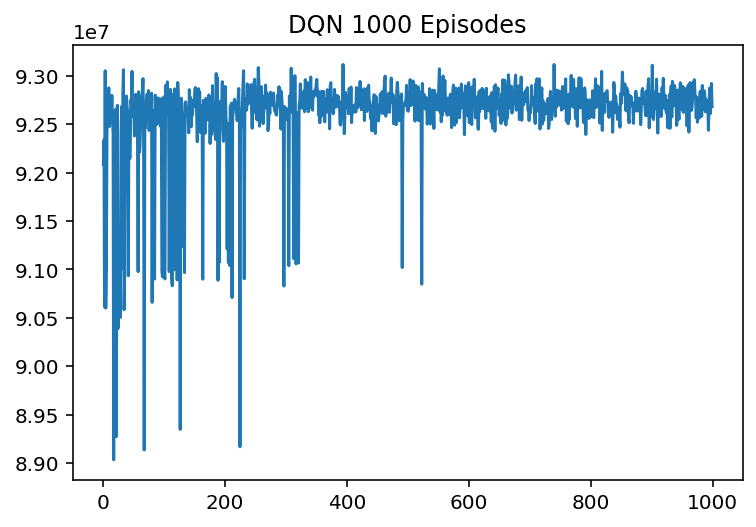

In [11]:
import seaborn as sns
%config InlineBackend.figure_format = "retina"
sns.lineplot(range(1,num_eps),ep_costs).set_title("DQN 1000 Episodes")

In [12]:
display(pd.Series(ep_costs).describe().reset_index())
pd.Series(ep_costs)[[0,1,2,5,10,25,50,100,250,500,998]].reset_index()

,index,0
0,count,9.990000e+02
1,mean,9.261236e+07
2,std,4.661077e+05
3,min,8.903343e+07
4,25%,9.259173e+07
5,50%,9.270331e+07
6,75%,9.280606e+07
7,max,9.311525e+07


,index,0
0,0,92084010
1,1,92336950
2,2,90611900
3,5,91094580
4,10,92474370
5,25,90793100
6,50,92720870
7,100,90937850
8,250,92830760
9,500,92632290


In [13]:
ep_costs=[]
num_eps=1000
for i in range(num_eps):
    summary_i = pd.read_csv(f"/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/src/experiments/aug_8_dqn_debugging/data/results/dqn2_few_warehouses_v2/ep_{i}/summary_movement_report.csv")
    ep_cost=summary_i.total_cost.sum()
    ep_costs.append(ep_cost)

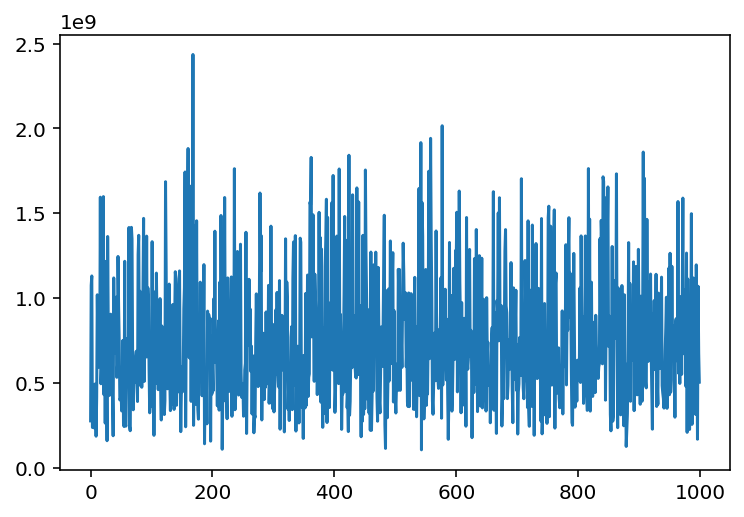

In [14]:
sns.lineplot(range(len(ep_costs)),ep_costs)

In [129]:
detail_0 = pd.read_csv(f"/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/src/experiments/aug_8_dqn_debugging/data/results/dqn2_few_warehouses_v2/ep_0/movement_detail_report.csv")
detail_999 = pd.read_csv(f"/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/src/experiments/aug_8_dqn_debugging/data/results/dqn2_few_warehouses_v2/ep_999/movement_detail_report.csv")
detail_0=add_is_m(detail_0)
detail_999=add_is_m(detail_999)

In [131]:
print(detail_0.query('customer_cost>0').groupby('is_m').size())
print(detail_999.query('customer_cost>0').groupby('is_m').size())

is_m
False    105
True      45
dtype: int64
is_m
False    110
True      40
dtype: int64
